In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zinc250k/250k_rndm_zinc_drugs_clean_3.csv


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 48.4 MB/s eta 0:00:00:00:0100:01


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install torch

In [5]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from rdkit import Chem
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool


In [6]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [7]:
# Load the dataset and select a subset of 10,000 rows
df = pd.read_csv('/kaggle/input/zinc250k/250k_rndm_zinc_drugs_clean_3.csv')  # Adjust path to your dataset
df_subset = df.head(50000)  # Select the first 10,000 rows

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


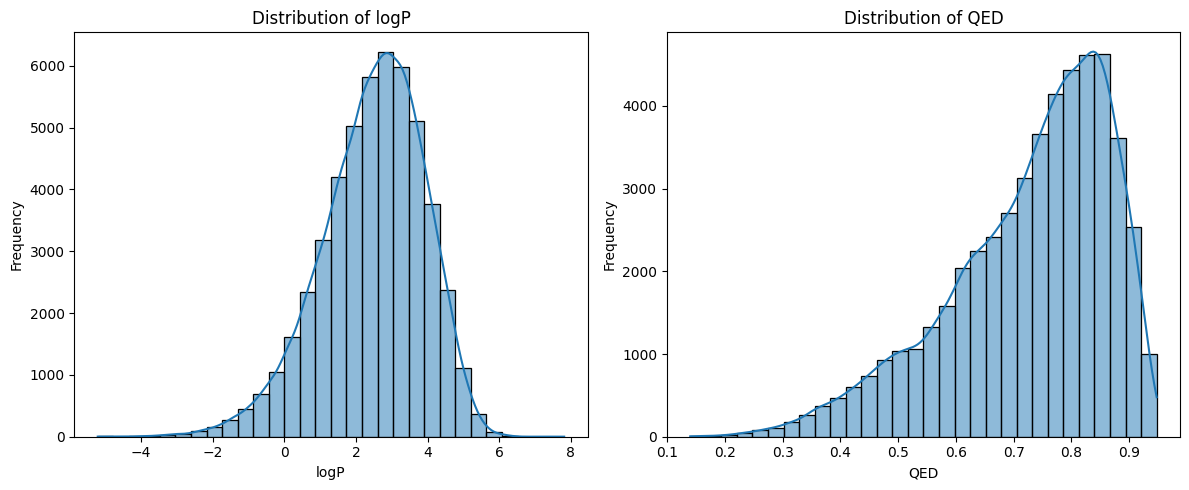

In [8]:

# EDA - Visualizing the distribution of logP, QED, and SAS
plt.figure(figsize=(12, 5))

# LogP distribution
plt.subplot(1, 2, 1)
sns.histplot(df_subset['logP'], bins=30, kde=True)
plt.title('Distribution of logP')
plt.xlabel('logP')
plt.ylabel('Frequency')

# QED distribution
plt.subplot(1, 2, 2)
sns.histplot(df_subset['qed'], bins=30, kde=True)
plt.title('Distribution of QED')
plt.xlabel('QED')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [9]:
# Correlation matrix for logP, QED, and SAS (if SAS exists)
if 'SAS' in df_subset.columns:
    correlation_df = df_subset[['logP', 'qed', 'SAS']]
else:
    correlation_df = df_subset[['logP', 'qed']]

correlation_matrix = correlation_df.corr()
print("Correlation matrix:\n", correlation_matrix)

Correlation matrix:
           logP       qed       SAS
logP  1.000000 -0.177761 -0.512706
qed  -0.177761  1.000000  0.104757
SAS  -0.512706  0.104757  1.000000


In [10]:
# Dropping missing values
df_subset = df_subset.dropna()


In [11]:

# Normalize target properties (logP, QED, and SAS) for the subset
scaler = MinMaxScaler()
df_subset[['logP', 'qed', 'SAS']] = scaler.fit_transform(df_subset[['logP', 'qed', 'SAS']])


In [12]:

# Load ChemBERTa model and tokenizer using RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
chemberta_model = RobertaModel.from_pretrained('seyonec/ChemBERTa-zinc-base-v1').to(device)  # Move ChemBERTa model to GPU

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [13]:
# Function to convert SMILES to ChemBERTa embeddings and run on GPU
def smiles_to_chemberta_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = chemberta_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

In [14]:

# Function to convert SMILES to molecular graphs using PyTorch Geometric
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atomic numbers as node features
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Undirected graph

        edge_type = bond.GetBondTypeAsDouble()
        edge_attr.append(edge_type)
        edge_attr.append(edge_type)  # Undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)  # Node features
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)  # Edge features

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [15]:
# Convert SMILES strings to molecular graphs and ChemBERTa embeddings for the subset
graphs = []
chemberta_embeddings = []

for smiles in tqdm(df_subset['smiles'], desc="Processing SMILES", total=len(df_subset['smiles'])):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)
        chemberta_embeddings.append(smiles_to_chemberta_embedding(smiles))

# Concatenate ChemBERTa embeddings with graph node features for the subset
for graph, chemberta_embedding in tqdm(zip(graphs, chemberta_embeddings), desc="Concatenating embeddings", total=len(graphs)):
    repeated_embedding = chemberta_embedding.repeat(graph.x.size(0), 1)
    graph.x = torch.cat([graph.x.to(device), repeated_embedding], dim=1)  # Move tensors to GPU

Concatenating embeddings: 100%|██████████| 50000/50000 [00:04<00:00, 11365.12it/s]


In [16]:
# Create separate data lists for (logP, QED) and SAS models for the subset
logp_qed_data = []
sas_data = []

for i, graph in enumerate(graphs):
    logp, qed, sas = df_subset.iloc[i][['logP', 'qed', 'SAS']]
    
    # Append (logP, QED) data
    logp_qed_graph = graph.clone()
    logp_qed_graph.y = torch.tensor([logp, qed], dtype=torch.float).view(1, 2).to(device)  # Ensure shape is [1, 2]
    logp_qed_data.append(logp_qed_graph)

    # Append SAS data
    sas_graph = graph.clone()
    sas_graph.y = torch.tensor([sas], dtype=torch.float).view(1, 1).to(device)  # Ensure shape is [1, 1]
    sas_data.append(sas_graph)


In [17]:

# Split data into train and test sets (Subset of 50K)
logp_qed_train, logp_qed_test = train_test_split(logp_qed_data, test_size=0.2, random_state=42)
sas_train, sas_test = train_test_split(sas_data, test_size=0.2, random_state=42)

In [18]:

# Create DataLoaders
logp_qed_train_loader = DataLoader(logp_qed_train, batch_size=32, shuffle=True)
logp_qed_test_loader = DataLoader(logp_qed_test, batch_size=32, shuffle=False)
sas_train_loader = DataLoader(sas_train, batch_size=32, shuffle=True)
sas_test_loader = DataLoader(sas_test, batch_size=32, shuffle=False)


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import BatchNorm

class ImprovedGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ImprovedGCN, self).__init__()
        
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)  # Batch normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Layer 1
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x1 = self.dropout(x1)

        # Layer 2 with residual connection
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x2 = self.dropout(x2)
        x2 += x1  # Skip connection

        # Layer 3 with residual connection
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x3 = self.dropout(x3)
        x3 += x2  # Skip connection

        # Global mean pooling
        x = global_mean_pool(x3, data.batch)
        
        # Final output layer with potential activation function
        out = self.fc(x)
        
        # Optional activation for regression (e.g., for logP and QED)
        return out  # You may add an activation function depending on your task

# Example of how to initialize the model
        model = ImprovedGCN(input_dim=your_input_dim, hidden_dim=64, output_dim=2)  # Adjust input_dim and output_dim accordingly


In [20]:

# Initialize separate models for (logP, QED) and SAS
input_dim = graphs[0].x.shape[1]  # Get input dimension from graph node features
hidden_dim = 64

logp_qed_model = ImprovedGCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2).to(device)  # Move model to GPU
sas_model = ImprovedGCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1).to(device)  # Move model to GPU

# Define optimizers and loss function (Mean Squared Error Loss)
criterion = torch.nn.MSELoss()
logp_qed_optimizer = optim.AdamW(logp_qed_model.parameters(), lr=0.001, weight_decay=1e-5)
sas_optimizer = optim.Adam(sas_model.parameters(), lr=0.01)


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)  # Ensure data is on the correct device
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Evaluation function with all metrics
def evaluate(model, loader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            # Calculate the loss
            loss = criterion(out, data.y.view(out.shape).to(device))
            total_loss += loss.item() * data.num_graphs

            y_true.extend(data.y.cpu().numpy())  # Collect actual values
            y_pred.extend(out.cpu().numpy())  # Collect predicted values

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Print metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")

    # Return average loss and all metrics
    return total_loss / len(loader.dataset), {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "mape": mape
    }



MSE: 0.0071
RMSE: 0.0845
MAE: 0.0625
R²: 0.6858
MAPE: 0.1098
MSE: 0.0017
RMSE: 0.0408
MAE: 0.0308
R²: 0.9174
MAPE: 0.1181
Epoch 1/15 - LogP/QED Train Loss: 0.0089, Val Loss: 0.0071
LogP/QED Metrics: MSE: 0.0071, RMSE: 0.0845, MAE: 0.0625, R²: 0.6858, MAPE: 0.1098
Epoch 1/15 - SAS Train Loss: 0.0027, Val Loss: 0.0017
SAS Metrics: MSE: 0.0017, RMSE: 0.0408, MAE: 0.0308, R²: 0.9174, MAPE: 0.1181
MSE: 0.0069
RMSE: 0.0831
MAE: 0.0628
R²: 0.6884
MAPE: 0.1045
MSE: 0.0018
RMSE: 0.0430
MAE: 0.0322
R²: 0.9082
MAPE: 0.1183
Epoch 2/15 - LogP/QED Train Loss: 0.0082, Val Loss: 0.0069
LogP/QED Metrics: MSE: 0.0069, RMSE: 0.0831, MAE: 0.0628, R²: 0.6884, MAPE: 0.1045
Epoch 2/15 - SAS Train Loss: 0.0024, Val Loss: 0.0018
SAS Metrics: MSE: 0.0018, RMSE: 0.0430, MAE: 0.0322, R²: 0.9082, MAPE: 0.1183
MSE: 0.0067
RMSE: 0.0817
MAE: 0.0623
R²: 0.6931
MAPE: 0.1041
MSE: 0.0016
RMSE: 0.0396
MAE: 0.0301
R²: 0.9220
MAPE: 0.1141
Epoch 3/15 - LogP/QED Train Loss: 0.0079, Val Loss: 0.0067
LogP/QED Metrics: MSE: 0.00

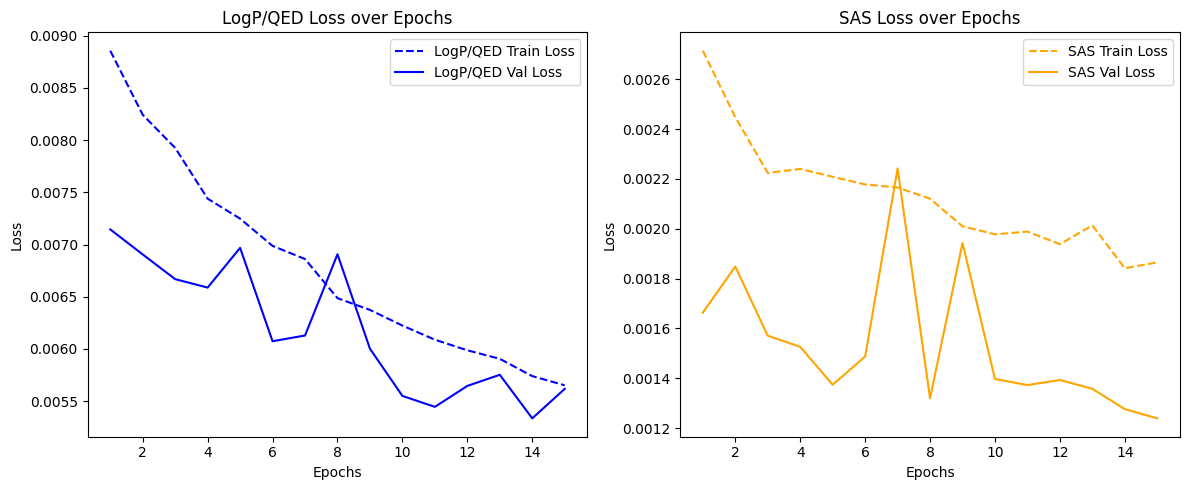

In [25]:
import matplotlib.pyplot as plt

# Lists to store metrics
logp_qed_train_losses = []
logp_qed_val_losses = []
sas_train_losses = []
sas_val_losses = []
logp_qed_metrics_list = []
sas_metrics_list = []

# Train both models for 15 epochs and evaluate them
epochs = 15
for epoch in range(epochs):
    # Training phase
    logp_qed_train_loss = train(logp_qed_model, logp_qed_train_loader, logp_qed_optimizer)
    sas_train_loss = train(sas_model, sas_train_loader, sas_optimizer)
    
    # Validation phase
  # Validation phase
    logp_qed_val_loss, logp_qed_metrics = evaluate(logp_qed_model, logp_qed_test_loader, criterion)  # All metrics for logP/QED
    sas_val_loss, sas_metrics = evaluate(sas_model, sas_test_loader, criterion)  # All metrics for SAS


        # Store losses and metrics
    logp_qed_train_losses.append(logp_qed_train_loss)
    logp_qed_val_losses.append(logp_qed_val_loss)
    sas_train_losses.append(sas_train_loss)
    sas_val_losses.append(sas_val_loss)
    logp_qed_metrics_list.append(logp_qed_metrics)
    sas_metrics_list.append(sas_metrics)

    # Print metrics for logP/QED
    print(f"Epoch {epoch+1}/{epochs} - LogP/QED Train Loss: {logp_qed_train_loss:.4f}, Val Loss: {logp_qed_val_loss:.4f}")
    print(f"LogP/QED Metrics: MSE: {logp_qed_metrics['mse']:.4f}, RMSE: {logp_qed_metrics['rmse']:.4f}, "
          f"MAE: {logp_qed_metrics['mae']:.4f}, R²: {logp_qed_metrics['r2']:.4f}, MAPE: {logp_qed_metrics['mape']:.4f}")

    # Print metrics for SAS
    print(f"Epoch {epoch+1}/{epochs} - SAS Train Loss: {sas_train_loss:.4f}, Val Loss: {sas_val_loss:.4f}")
    print(f"SAS Metrics: MSE: {sas_metrics['mse']:.4f}, RMSE: {sas_metrics['rmse']:.4f}, "
          f"MAE: {sas_metrics['mae']:.4f}, R²: {sas_metrics['r2']:.4f}, MAPE: {sas_metrics['mape']:.4f}")

# Plotting loss curves
plt.figure(figsize=(12, 5))

# Plot for logP/QED Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), logp_qed_train_losses, label='LogP/QED Train Loss', color='blue', linestyle='--')
plt.plot(range(1, epochs + 1), logp_qed_val_losses, label='LogP/QED Val Loss', color='blue')
plt.title('LogP/QED Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for SAS Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), sas_train_losses, label='SAS Train Loss', color='orange', linestyle='--')
plt.plot(range(1, epochs + 1), sas_val_losses, label='SAS Val Loss', color='orange')
plt.title('SAS Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
